In [2]:
import scipy as sp
import numpy as np
import qibo
from qibo.symbols import *
from qibo import hamiltonians
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import unitary_group

from functions import *

In [47]:

def matrixPolynomialEvolutionDBI(initState, H, coeffs, method = "DBI", rootSelection = False):

    steps = len(coeffs)
    state = initState.copy()
    coeffs2 = coeffs.copy()
    energy = np.zeros(steps)

    for i in range(steps):

        # pick the coefficient such that np.abs(E-coeff) is maximized
        if rootSelection:
            coeff = coeffs2[np.argmax(np.abs(coeffs2 - energy))]
            coeffs2 = np.delete(coeffs2, np.argmax(np.abs(coeffs2 - energy)))
        else:
            coeff = coeffs[i]

        s, theta = matrixPolynomialScheduling(state, H, coeff)
        rho = np.outer(state, state.conj())
        W = commutator(rho, H)

        t = np.sign(s)*np.sqrt(np.abs(s))

        if method == "DBI":
            state = sp.linalg.expm(1j*theta*rho) @ sp.linalg.expm(s*W) @ state
        elif method == "DBQITE":
            state = sp.linalg.expm(-1j*theta*rho) @ sp.linalg.expm(1j*t*H) @ sp.linalg.expm(1j*t*rho) @ sp.linalg.expm(-1j*t*H) @ state
        elif method == "DBQITE3":
            phi = (1+np.sqrt(5)/2)
            ref1 = sp.linalg.expm(1j*phi*t*rho)
            ref2 = sp.linalg.expm(-1j*(phi+1)*t*rho)
            U = sp.linalg.expm(-1j*theta*rho) @ sp.linalg.expm(1j*phi*t*H) @ ref1 @ sp.linalg.expm(-1j*t*H) @ ref2 @ sp.linalg.expm(1j*(1-phi)*t*H)
            state = U @ state

        energy[i] = np.real(np.vdot(state, H @ state)) 
        
    state = state / np.linalg.norm(state)
    return state, energy

[Qibo 0.2.16|WARNING|2025-04-11 10:09:46]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


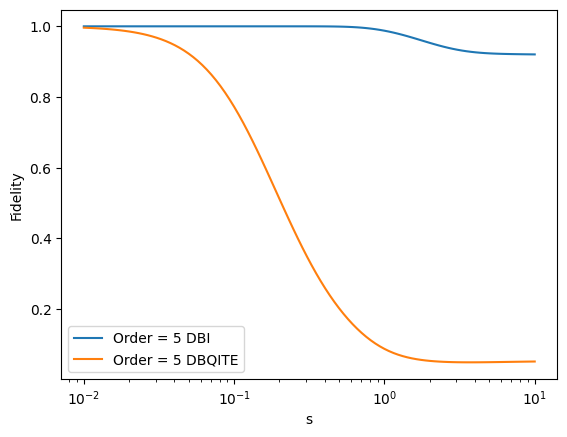

In [14]:
nqubits = 6

H_def = sum([X(x)-Z(x+1)*Z(x)   for x in range(nqubits-1)])
H = -hamiltonians.SymbolicHamiltonian(H_def).matrix
initState = np.random.rand(2**nqubits)
initState = initState / np.linalg.norm(initState)

s = np.logspace(-2, 1, 100)
order = [5]
plt.figure()
for i in range(len(order)):
    fidelityDBI = np.zeros(len(s))
    fidelityDBQITE = np.zeros(len(s))
    
    for j in range(len(s)):
        state = sp.linalg.expm(-s[j]*H) @ initState
        state /= np.linalg.norm(state)
        coeffs = findRoots(order[i], -s[j])
        stateDBI = matrixPolynomialEvolutionDBI(initState, H, coeffs, method = "DBI")
        fidelityDBI[j] = Fidelity(stateDBI, state)
        stateDBQITE = matrixPolynomialEvolutionDBI(initState, H, coeffs, method = "DBQITE")
        fidelityDBQITE[j] = Fidelity(stateDBQITE, state)

    plt.plot(s, fidelityDBI, label=f"Order = {order[i]} DBI")
    plt.plot(s, fidelityDBQITE, label=f"Order = {order[i]} DBQITE")
plt.xlabel("s")
plt.xscale("log")
plt.ylabel("Fidelity")
plt.legend()



Text(0.5, 1.0, 'Roots of the polynomial')

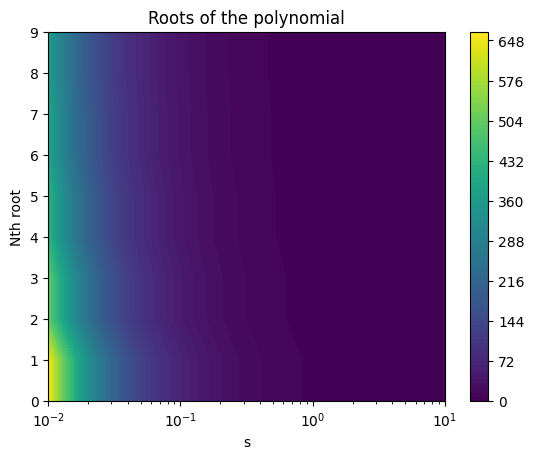

In [18]:
roots = np.zeros((10, len(s)), dtype=complex)
s = np.logspace(-2, 1, 100)
for j in range(len(s)):
        coeffs = findRoots(10, -s[j])
        roots[:,j] = coeffs
plt.figure()
plt.contourf(s, np.arange(10), np.abs(roots), levels=100)
plt.colorbar()
plt.xscale("log")
plt.xlabel("s")
plt.ylabel("Nth root")
plt.title("Roots of the polynomial")

In [ ]:

def thermalStatePrepMatrixPolynomial(H, nqubits, beta, order):
    """
    Prepares the TFD state at temperature beta and compares it with the final state obtained by the DBI or DBQITE algorithm.
    """
    initState = tfd0(nqubits)
    tfd = TFD(beta, H, initState)
    coeffs = findRoots(order, -beta/2)

    newState = matrixPolynomialEvolutionDBI(initState, H, coeffs)
    fidelity = Fidelity(tfd, newState)

    return fidelity

def thermalStatePrepMatrixPolynomialSteps(H, nqubits, beta, epsilon):
    """
    Prepares the TFD state at temperature beta and compares it with the final state obtained by the DBI or DBQITE algorithm.
    """
    initState = tfd0(nqubits)
    tfd = TFD(beta, H, initState)
    order = 0
    fidelity = Fidelity(tfd, initState)
    while fidelity < 1-epsilon:
        order += 1
        coeffs = findRoots(order, -beta/2)
        newState = matrixPolynomialEvolutionDBI(initState, H, coeffs)
        fidelity = Fidelity(tfd, newState)

    return order

[Qibo 0.2.16|WARNING|2025-04-11 09:53:55]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


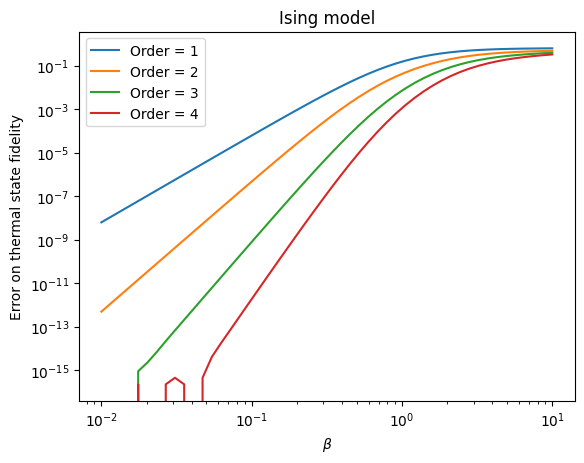

In [4]:
nqubits = 4
H_def = sum([X(x)-Z(x+1)*Z(x)   for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
H = np.kron(H ,np.eye(2**nqubits))
initState = tfd0(nqubits)

beta = np.logspace(-2, 1, 50)
order = np.arange(1, 5)
fidelity = np.zeros(len(beta))

plt.figure()
plt.title("Ising model")
for j in range(len(order)):
    fidelity = np.zeros(len(beta))
    for i in range(len(beta)):
        fidelity[i] = thermalStatePrepMatrixPolynomial(H, nqubits, beta[i], order[j])

    plt.plot(beta, 1-fidelity, label=f"Order = {order[j]}")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\beta$")
plt.ylabel("Error on thermal state fidelity")
plt.legend()
plt.show()


[Qibo 0.2.16|WARNING|2025-04-03 15:10:21]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


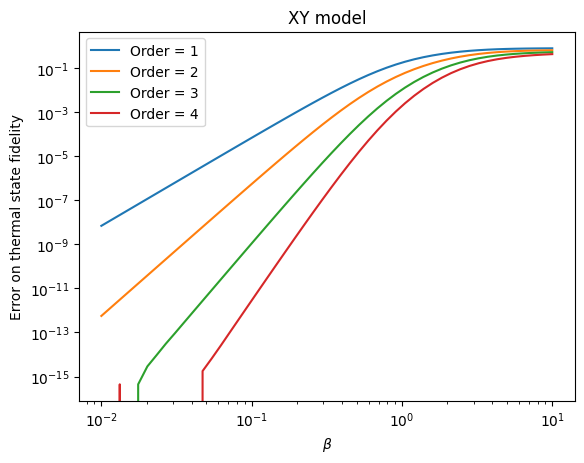

In [ ]:
nqubits = 4
H_def = sum([X(x)*X(x+1)+Y(x)*Y(x+1)  for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
H = np.kron(H ,np.eye(2**nqubits))
initState = tfd0(nqubits)

beta = np.logspace(-2, 1, 50)
order = np.arange(1, 5)
fidelity = np.zeros(len(beta))

plt.figure()
plt.title("XY model")
for j in range(len(order)):
    fidelity = np.zeros(len(beta))
    for i in range(len(beta)):
        fidelity[i] = thermalStatePrepMatrixPolynomial(H, nqubits, beta[i], order[j])

    plt.plot(beta, 1-fidelity, label=f"Order = {order[j]}")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\beta$")
plt.ylabel("Error on thermal state fidelity")
plt.legend()
plt.show()


[Qibo 0.2.16|WARNING|2025-04-03 15:10:48]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


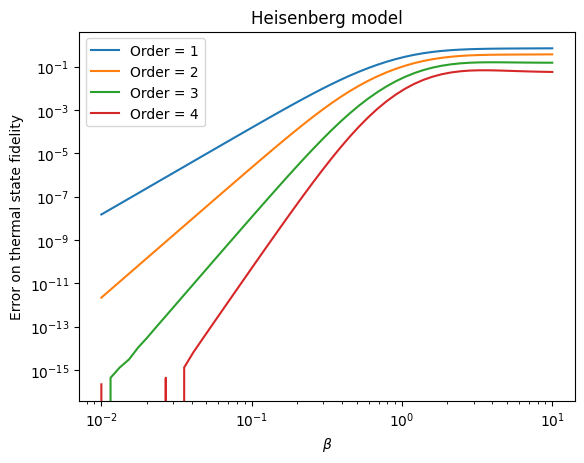

In [ ]:
nqubits = 4
H_def = sum([X(x)*X(x+1)+Y(x)*Y(x+1)+Z(x+1)*Z(x)  for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
H = np.kron(H ,np.eye(2**nqubits))

beta = np.logspace(-2, 1, 50)
order = np.arange(1, 5)
fidelity = np.zeros(len(beta))

plt.figure()
plt.title("Heisenberg model")
for j in range(len(order)):
    fidelity = np.zeros(len(beta))
    for i in range(len(beta)):
        fidelity[i] = thermalStatePrepMatrixPolynomial(H, nqubits, beta[i], order[j])

    plt.plot(beta, 1-fidelity, label=f"Order = {order[j]}")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\beta$")
plt.ylabel("Error on thermal state fidelity")
plt.legend()
plt.show()


[Qibo 0.2.16|WARNING|2025-04-03 15:44:12]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
100%|██████████| 30/30 [17:05<00:00, 34.18s/it] 


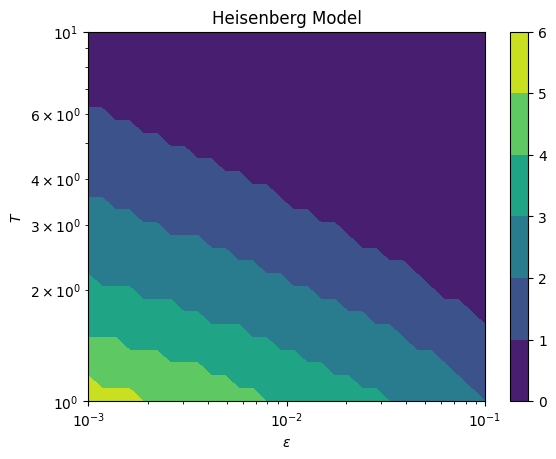

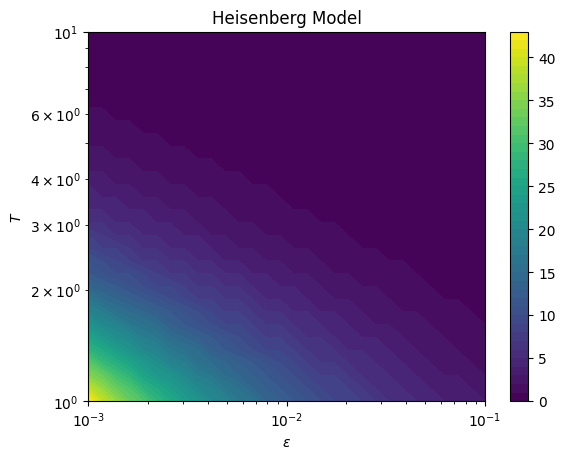

In [ ]:
nqubits = 4
H_def = sum([X(x)*X(x+1)+Y(x)*Y(x+1)+Z(x+1)*Z(x)  for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
H = np.kron(H, np.eye(2**nqubits))

beta = np.logspace(-1, 0, 30)
epsilon = np.logspace(-3, -1, 30)
order = np.zeros((len(beta), len(epsilon)))
K = np.zeros((len(beta), len(epsilon)))

for i in tqdm(range(len(beta))):
    for j in range(len(epsilon)):
        order[i,j] = thermalStatePrepMatrixPolynomialSteps(H, nqubits, beta[i], epsilon[j])
        K[i,j] = thermalStatePrepKNumbers(beta[i], epsilon[j], H, nqubits)

plt.figure()
plt.title('Heisenberg Model')
plt.contourf(epsilon, 1/beta, order, levels = np.arange(0, np.max(order)+1, 1))
plt.ylabel(r'$T$')
plt.xlabel(r'$\epsilon$')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

plt.figure()
plt.title('Heisenberg Model')
plt.contourf(epsilon, 1/beta, K, levels = np.arange(0, np.max(K)+1, 1))
plt.ylabel(r'$T$')
plt.xlabel(r'$\epsilon$')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()



In [168]:
def inversePolynomial(a, K, x):
    g = 0
    for l in range(0, K+1):
        term = 0    
        for j in range(l+1, a+1):
            term += sp.special.comb(2*a, a+j, exact=True)
        term *= (-1)**l / 2**(2*a) * sp.special.eval_chebyt(2*l+1, x)
        g += term
    return 4*g

def matrixCheby(n, A):
    I = np.eye(A.shape[0])
    if n == 0:
        return I
    elif n == 1:
        return A
    T0, T1 = I, A
    for _ in range(2, n + 1):
        T2 = 2 * A @ T1 - T0
        T0, T1 = T1, T2
    return T1

def inversePolynomialMatrix(a, K, X):
    g = np.zeros_like(X, dtype=type(X))
    for l in range(0, K+1):
        term = 0
        for j in range(l+1, a+1):
            term += sp.special.comb(2*a, a + j, exact=True)
        
        T = matrixCheby(2*l + 1, X)
        
        term *= ((-1)**l / (2**(2*a))) * T
        g += term
    
    return 4 * g

def inversePolynomialCoefficients(a, K):
    max_degree = 2 * K + 1
    coefficients = np.zeros(max_degree + 1)

    for l in range(0, K + 1):
        # Compute the binomial coefficient sum
        bin_sum = sum(sp.special.comb(2 * a, a + j, exact=False) for j in range(l + 1, a + 1))
        
        # Compute the weight for this term
        coeff = (-1)**l / (2**(2 * a)) * bin_sum

        # Get Chebyshev polynomial T_{2l+1}
        cheb_poly = np.polynomial.Chebyshev.basis(2 * l + 1)

        # Convert Chebyshev polynomial to monomial basis
        mono_poly = cheb_poly.convert(kind=np.polynomial.Polynomial)
        mono_coeffs = mono_poly.coef  # Already in ascending order

        # Pad to the right length
        padded = np.zeros_like(coefficients)
        padded[:len(mono_coeffs)] = mono_coeffs

        # Accumulate contribution
        coefficients += 4 * coeff * padded

    return coefficients

def inversePolynomialRoots(a, K):
    # Get the polynomial coefficients
    coeffs = inversePolynomialCoefficients(a, K)
    
    # The coefficients are from highest degree to lowest, so reverse for np.roots
    roots = np.roots(coeffs[::-1])
        
    return np.array(roots)

a = 12, K = 9


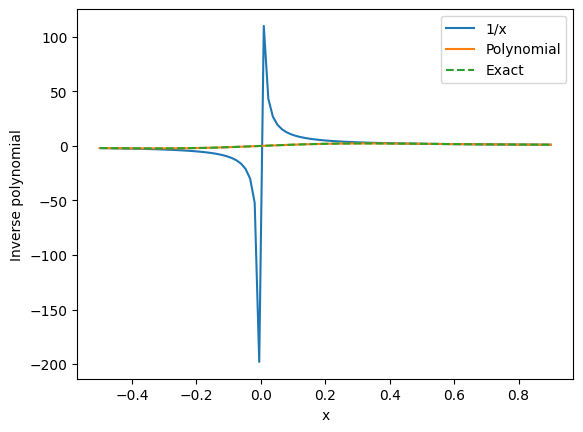

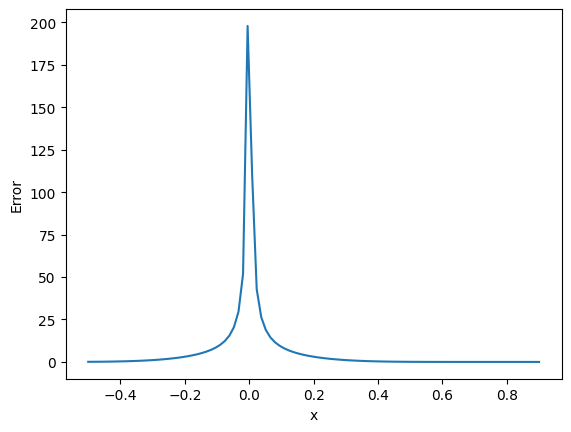

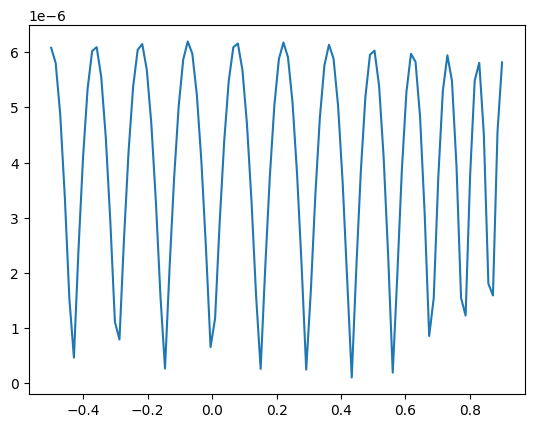

In [192]:
x = np.linspace(-0.5, 0.9, 100)
kappa = 2
eps = 0.1
tau = 1.0
a = int(np.ceil(kappa**2*np.log(kappa/eps)))
K = int(np.ceil(np.sqrt(a*np.log(4*a/eps))))
print(f"a = {a}, K = {K}")
coeffs = inversePolynomialCoefficients(a, K)
plt.figure()
#plt.plot(x, np.polyval(coeffs[::-1], x), label='Polynomial')
plt.plot(x,1/x, label = '1/x')
plt.plot(x, inversePolynomial(a, K, x), label='Polynomial')
plt.plot(x, (1-(1-(x**tau)**2)**a)/x**tau, '--', label = 'Exact')
plt.xlabel("x")
plt.ylabel("Inverse polynomial")
plt.legend()
plt.show()

roots = inversePolynomialRoots(a, K)


plt.figure()
plt.plot(x, np.abs(1/x-(1-(1-x**2)**a)/x))
plt.xlabel("x")
plt.ylabel("Error")

plt.figure()
plt.plot(x, np.abs((1-(1-x**2)**a)/x-inversePolynomial(a, K, x)))

[Qibo 0.2.16|WARNING|2025-04-07 15:32:43]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
100%|██████████| 100/100 [00:01<00:00, 67.88it/s]


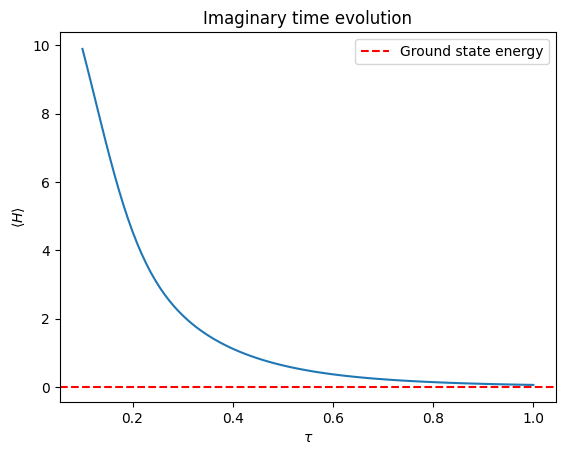

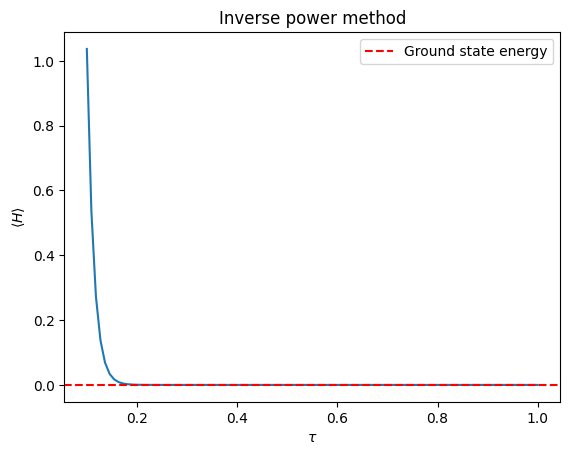

In [209]:
nqubits = 6
H_def = sum([X(x)*X(x+1)+Y(x)*Y(x+1)+Z(x+1)*Z(x)  for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
E0 = np.linalg.eigvalsh(H)[0]   
a = E0
H = (H-a*np.eye(2**nqubits))
state = np.random.rand(2**nqubits)
state /= np.linalg.norm(state)
H_inv = np.linalg.inv(H)
E0 = np.linalg.eigvalsh(H)[0]

tau = np.linspace(0.1, 1, 100)
E = np.zeros(len(tau))
E2 = np.zeros(len(tau))

for t in tqdm(range(len(tau))):

    stateEvol = sp.linalg.fractional_matrix_power(H_inv, tau[t]) @ state
    stateEvol /= np.linalg.norm(stateEvol)
    E[t] = np.real(stateEvol.conj().T @ H @ stateEvol)

    stateEvol = sp.linalg.expm(-tau[t]*H) @ state
    stateEvol /= np.linalg.norm(stateEvol)
    E2[t] = np.real(stateEvol.conj().T @ H @ stateEvol)

plt.figure()
plt.plot(tau, E2)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\langle H \rangle$")
plt.title("Imaginary time evolution")
plt.axhline(E0, color='red', linestyle='--', label = 'Ground state energy')
plt.legend()
plt.show()

plt.figure()
plt.plot(tau, E)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\langle H \rangle$")
plt.title("Inverse power method")
plt.axhline(E0, color='red', linestyle='--', label = 'Ground state energy')
plt.legend()
plt.show()

[Qibo 0.2.16|WARNING|2025-04-10 09:30:12]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
C:\Users\andre\AppData\Local\Temp\ipykernel_21188\1346928543.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  distance2[k,i] = np.linalg.norm(invApprox-invApproxPoly)


<Figure size 640x480 with 0 Axes>

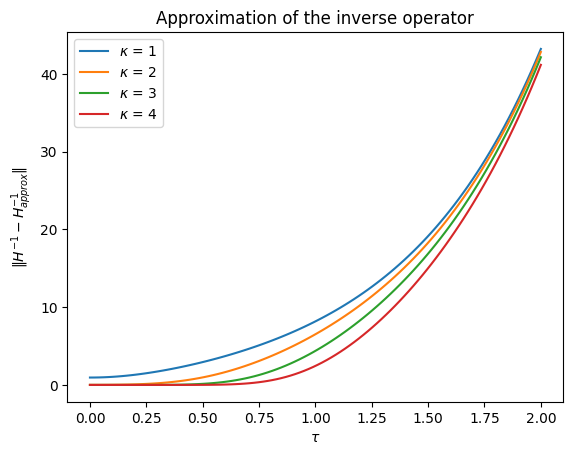

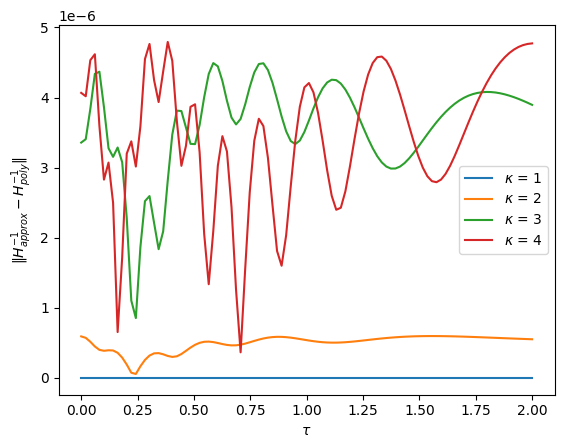

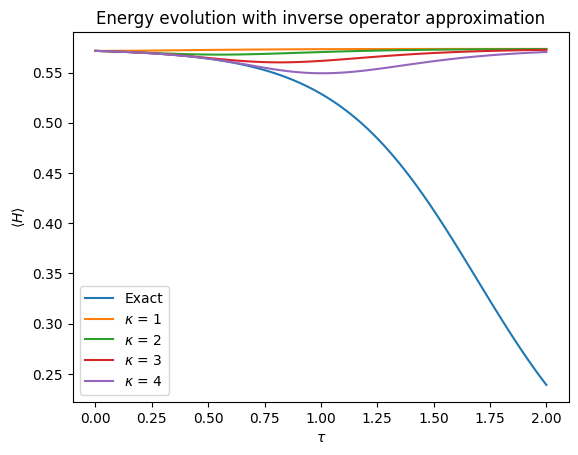

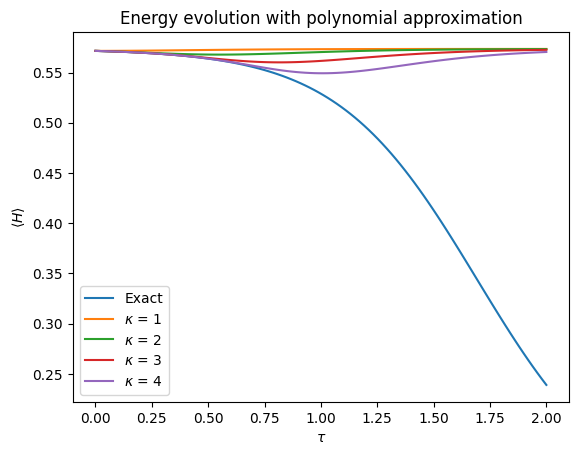

In [575]:
np.random.seed(0)
nqubits = 2
H_def = sum([X(x)*X(x+1)+Y(x)*Y(x+1)+Z(x+1)*Z(x)  for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
E0 = np.linalg.eigvalsh(H)[0]   
mu = (E0-1)
H = (H-mu*np.eye(2**nqubits))
H /= np.linalg.norm(H)
E0 = np.linalg.eigvalsh(H)[0]
state = np.random.rand(2**nqubits)
state /= np.linalg.norm(state)
inv = np.linalg.inv(H)
kappa = np.arange(1,5,1)
eps = 0.01


tau = np.linspace(0.0, 2.0, 100)

I = np.eye(2**nqubits)
plt.figure()
energyInverse = np.zeros(len(tau))
energyApprox = np.zeros((len(kappa), len(tau)))
energyPolynomial = np.zeros((len(kappa), len(tau)))
distance = np.zeros((len(kappa),len(tau)))
distance2 = np.zeros((len(kappa),len(tau)))

for i in range(len(tau)):
    Htau = sp.linalg.fractional_matrix_power(H, tau[i])
    Htau /= np.linalg.norm(Htau)
    Hmtau = np.linalg.inv(Htau)
    newState = Hmtau @ state
    newState /= np.linalg.norm(newState)
    energyInverse[i] = np.real(newState.conj().T @  H  @ newState)
    

    for k in range(len(kappa)):
        a = int(np.ceil(kappa[k]**2*np.log(kappa[k]/eps)))
        K = int(np.ceil(np.sqrt(a*np.log(4*a/eps))))
        op = np.linalg.matrix_power(I - Htau@Htau, a)
        invApprox = (I-op)@Hmtau
        invApproxPoly = inversePolynomialMatrix(a, K, Htau)
        distance[k,i] = np.linalg.norm(Hmtau-invApprox)
        distance2[k,i] = np.linalg.norm(invApprox-invApproxPoly)
        newState = invApprox @ state
        newState /= np.linalg.norm(newState)
        energyApprox[k,i] = np.real(newState.conj().T @ H @ newState)
        newState = invApproxPoly @ state
        newState /= np.linalg.norm(newState)
        energyPolynomial[k,i] = np.real(newState.conj().T @ H @ newState)

        
plt.figure()
for k in range(len(kappa)):
    plt.plot(tau, distance[k,:], label = fr"$\kappa$ = {kappa[k]}")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\|H^{-1}-H^{-1}_{approx}\|$")
plt.title("Approximation of the inverse operator")
plt.legend()
plt.show()

plt.figure()
for k in range(len(kappa)):
    plt.plot(tau, distance2[k,:], label = fr"$\kappa$ = {kappa[k]}")
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\|H^{-1}_{approx}-H^{-1}_{poly}\|$")
plt.show()

plt.figure()
plt.title("Energy evolution with inverse operator approximation")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\langle H \rangle$")
plt.plot(tau, energyInverse, label = 'Exact')

for k in range(len(kappa)):
    plt.plot(tau, energyApprox[k,:], label = fr"$\kappa$ = {kappa[k]}")
plt.legend()
plt.show()

plt.figure()
plt.title("Energy evolution with polynomial approximation")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\langle H \rangle$")
plt.plot(tau, energyInverse, label = 'Exact')

for k in range(len(kappa)):
    plt.plot(tau, energyPolynomial[k,:], label = fr"$\kappa$ = {kappa[k]}")
plt.legend()
plt.show()




[Qibo 0.2.16|WARNING|2025-04-09 14:20:00]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


c:\Users\andre\Desktop\EPFL\Master-Project\Master-Project\functions.py:394: RuntimeWarning: divide by zero encountered in scalar divide
  s = -1 / np.sqrt(V) * np.arccos( np.abs(E-coeff) / np.sqrt(V + np.abs(E-coeff)**2) )
c:\Users\andre\Desktop\EPFL\Master-Project\Master-Project\functions.py:394: RuntimeWarning: invalid value encountered in scalar multiply
  s = -1 / np.sqrt(V) * np.arccos( np.abs(E-coeff) / np.sqrt(V + np.abs(E-coeff)**2) )
c:\Users\andre\Desktop\EPFL\Master-Project\Master-Project\functions.py:395: RuntimeWarning: invalid value encountered in scalar divide
  theta = np.angle ( (E-coeff) / np.abs(E-coeff) )
c:\Users\andre\Desktop\EPFL\Master-Project\Master-Project\functions.py:425: RuntimeWarning: invalid value encountered in divide
  state = state / np.linalg.norm(state)
C:\Users\andre\AppData\Local\Temp\ipykernel_21188\2914185294.py:39: RuntimeWarning: invalid value encountered in divide
  newState /= np.linalg.norm(newState)
c:\Users\andre\Desktop\EPFL\Master-Proje

<Figure size 640x480 with 0 Axes>

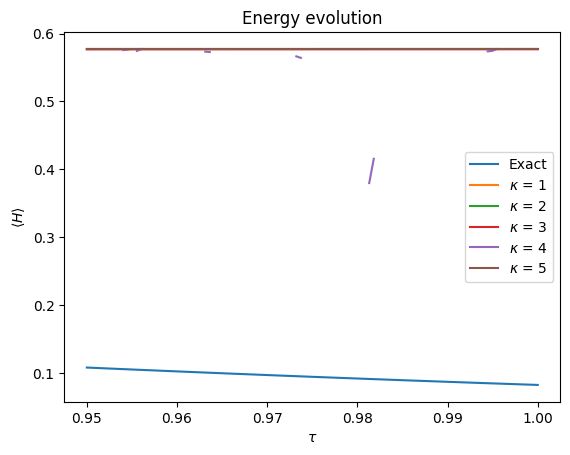

In [283]:
np.random.seed(0)
nqubits = 2
H_def = sum([X(x)*X(x+1)+Y(x)*Y(x+1)+Z(x+1)*Z(x)  for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
E0 = np.linalg.eigvalsh(H)[0]   
a = (E0-0.1)
H = (H-a*np.eye(2**nqubits))
H /= np.linalg.norm(H)
E0 = np.linalg.eigvalsh(H)[0]
state = np.random.rand(2**nqubits)
state /= np.linalg.norm(state)
inv = np.linalg.inv(H)
inv /= np.linalg.norm(inv)
kappa = np.arange(1,6,1)
eps = 0.01


tau = np.linspace(0.95, 1.0, 100)

I = np.eye(2**nqubits)
plt.figure()
energyInverse = np.zeros(len(tau))
energyApprox = np.zeros((len(kappa), len(tau)))

for i in range(len(tau)):
    Htau = sp.linalg.fractional_matrix_power(H, tau[i])
    Htau /= np.linalg.norm(Htau)
    Hmtau = sp.linalg.fractional_matrix_power(inv, tau[i])
    Hmtau /= np.linalg.norm(Hmtau)
    newState = Hmtau @ state
    newState /= np.linalg.norm(newState)
    energyInverse[i] = np.real(newState.conj().T @ H @ newState)

    for k in range(len(kappa)):
        a = int(np.ceil(kappa[k]**2*np.log(kappa[k]/eps)))
        K = int(np.ceil(np.sqrt(a*np.log(4*a/eps))))
        coeffs = inversePolynomialRoots(a, K)
        newState = thermalStatePrepMatrixPolynomialState(Htau, coeffs, state)
        newState /= np.linalg.norm(newState)
        energyApprox[k,i] = np.real(newState.conj().T @ H @ newState)

plt.figure()
plt.title("Energy evolution")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\langle H \rangle$")
plt.plot(tau, energyInverse, label = 'Exact')

for k in range(len(kappa)):
    plt.plot(tau, energyApprox[k,:], label = fr"$\kappa$ = {kappa[k]}")
plt.legend()
plt.show()




In [291]:
H_def = sum([X(x)*X(x+1)+Y(x)*Y(x+1)+Z(x+1)*Z(x)  for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
H = H@H
H /= np.linalg.norm(H)

inv = np.linalg.inv(H)
inv = inv/np.linalg.norm(inv)
kappa = np.arange(1,6,1)
eps = 0.01
I = np.eye(2**nqubits)
for i in range(len(kappa)):
    a = int(np.ceil(kappa[i]**2*np.log(kappa[i]/eps)))
    K = int(np.ceil(np.sqrt(a*np.log(4*a/eps))))
    inv_approx = (I-sp.linalg.fractional_matrix_power(I-H@H, a))@inv
    inv_approx_poly = inversePolynomialMatrix(a, K, H)
    distance = np.linalg.norm(inv-inv_approx)
    distance2 = np.linalg.norm(inv_approx-inv_approx_poly)
    print(f"Distance for kappa = {kappa[i]}: {distance}")
    print(f"Distance for kappa = {kappa[i]}: {distance2}")

[Qibo 0.2.16|WARNING|2025-04-09 14:25:25]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


Distance for kappa = 1: 0.9399445956905416
Distance for kappa = 1: (1.2877936538997297+0j)
Distance for kappa = 2: 0.7667997498749237
Distance for kappa = 2: (3.5754828906111977+0j)
Distance for kappa = 3: 0.5353602868342602
Distance for kappa = 3: (6.961595945104537+0j)
Distance for kappa = 4: 0.31607753503380415
Distance for kappa = 4: (10.209443015812628+0j)
Distance for kappa = 5: 0.15407139281827484
Distance for kappa = 5: (12.615944166077528+0j)


In [359]:
def inverseTaylorSeries(H, mu, order):
    result = np.zeros_like(H, dtype=complex)
    for i in range(order+1):
        result += np.linalg.matrix_power(H, i) / (mu**(i+1))
    return -result

def inverseTaylorSeriesCoefficients(mu, order):
    coeffs = np.zeros(order+1)
    coeffs[0] = -1/mu
    for i in range(1, order+1):
        coeffs[i] = -1 / (mu**(i+1))
    return coeffs

[Qibo 0.2.16|WARNING|2025-04-09 15:12:57]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


Spectral radius condition: -0.18221461881902376 (should be < 1)
0.7288584752760949


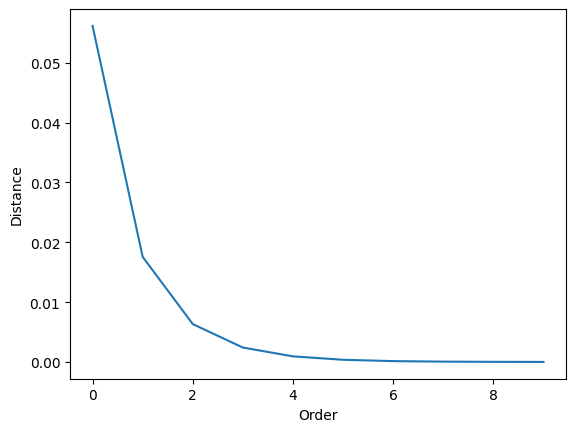

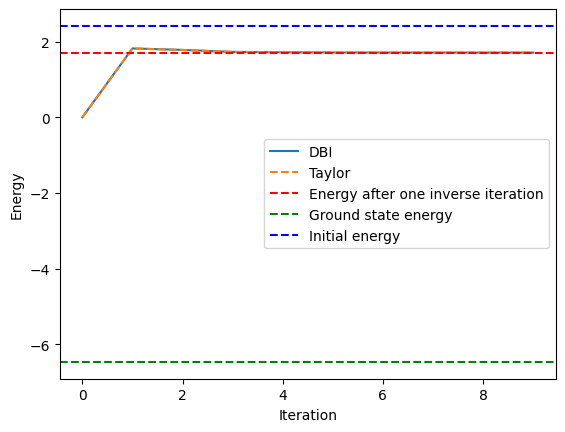

In [520]:
np.random.seed(0)
nqubits = 4
H_def = sum([X(x)*X(x+1)+Y(x)*Y(x+1)+Z(x+1)*Z(x)  for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
Emax = np.linalg.eigvalsh(H)[-1]
E0 = np.linalg.eigvalsh(H)[0]
mu = E0 - 10.0
max_eigval = np.linalg.eigvalsh(H)[-1]
print(f"Spectral radius condition: {max_eigval/mu} (should be < 1)")
print(np.linalg.norm(H/mu))

inverseTrue = np.linalg.inv(H-mu*np.eye(2**nqubits))
order = 10
distance = np.zeros(order)
for i in range(order):
    inverseApprox = inverseTaylorSeries(H, mu, i)
    distance[i] = np.linalg.norm(inverseTrue-inverseApprox)

plt.figure()
plt.plot(range(order), distance)
plt.xlabel("Order")
plt.ylabel("Distance")

initState = np.random.rand(2**nqubits)
initState /= np.linalg.norm(initState)
iters = 10
ETaylor = np.empty(iters)
Einit = np.real(initState.conj().T @ H @ initState)
EDBI = np.empty(iters)
state = inverseTrue @ initState
state /= np.linalg.norm(state)
Einv = np.real(state.conj().T @ H @ state)
for i in range(1,iters):
    coeffs = inverseTaylorSeriesCoefficients(mu, i)
    coeffs = np.flip(coeffs)
    roots = np.roots(coeffs)
    newState = thermalStatePrepMatrixPolynomialState(H, roots, initState)
    EDBI[i] = np.real(newState.conj().T @ H @ newState)
    invTaylor = inverseTaylorSeries(H, mu, i)
    newState = invTaylor @ initState
    newState /= np.linalg.norm(newState)
    ETaylor[i] = np.real(newState.conj().T @ H @ newState)

plt.figure()
plt.plot(EDBI, label = 'DBI')
plt.plot(ETaylor, '--', label = 'Taylor')
plt.axhline(Einv, color='red', linestyle='--', label = 'Energy after one inverse iteration')
plt.axhline(E0, color='green', linestyle='--', label = 'Ground state energy')
plt.axhline(Einit, color='blue', linestyle='--', label = 'Initial energy')
plt.legend()
plt.ylabel("Energy")
plt.xlabel("Iteration")
plt.show()

In [714]:
def sgn(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

def sgnPolyApproximation(x, order):
    result = 0
    for i in range(order+1):
        coeff = (-1)**i/(2*i+1) * sp.special.eval_chebyt(2*i+1, x)
        result -= coeff
    return 2/np.pi* result + 0.5

def sgnPolyCoefficients(order):
    max_degree = 2 * order + 1
    coefficients = np.zeros(max_degree + 1)  # Index = degree
    
    for i in range(order + 1):
        # Compute the coefficient for this term
        coeff = (-1)**i / (2*i + 1)
        
        # Get Chebyshev polynomial of degree 2i+1
        c = np.zeros(2*i + 2)
        c[2*i + 1] = 1  # This represents T_{2i+1}(x)
        cheb_poly = np.polynomial.chebyshev .Chebyshev(c)
        
        # Convert to standard polynomial basis
        poly = cheb_poly.convert(kind=np.polynomial.Polynomial)
        
        # Get coefficients in ascending order (x^0, x^1, ..., x^n)
        mono_coeffs = poly.coef
        
        # Pad to match our coefficient array length
        padded = np.zeros_like(coefficients)
        padded[:len(mono_coeffs)] = mono_coeffs
        
        # Accumulate the contribution
        coefficients -= (2/np.pi) * coeff * padded

    coefficients[0] += 0.5
    return coefficients

1.1102230246251565e-15
-4.440892098500626e-16
0.0


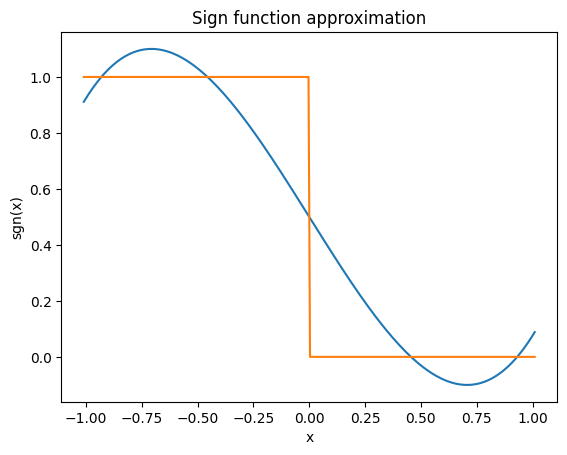

In [776]:
x = np.linspace(-1.01, 1.01, 300)
order = 1
coeffs = sgnPolyCoefficients(order)
roots = np.roots(coeffs[::-1])

plt.figure()
plt.plot(x, sgnPolyApproximation(x, order), label='Polynomial approximation')
plt.plot(x, 0.5*(1-np.sign(x)), label='Sign function')

plt.xlabel("x")
plt.ylabel("sgn(x)")
plt.title("Sign function approximation")

for root in roots:
    print(sgnPolyApproximation(root, order))


In [832]:
def getGap(H):
    """
    Compute the gap of the Hamiltonian H.
    """
    eigvals = np.linalg.eigvalsh(H)
    i = 0
    gap = eigvals[i+1] - eigvals[i]
    while gap < 1e-10 and i < len(eigvals)-1:
        i += 1
        gap = eigvals[i+1] - eigvals[i]
    return gap

[Qibo 0.2.16|WARNING|2025-04-10 10:52:48]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


[-9.97430854 -8.00798143 -8.00798143 -8.00798143 -5.68584617 -5.68584617
 -5.68584617 -4.74090768 -4.05682811 -4.05682811 -4.05682811 -3.491155
 -3.491155   -3.491155   -3.         -2.46410162 -2.46410162 -2.46410162
 -2.46410162 -2.46410162 -1.94136684 -1.94136684 -1.94136684 -1.
 -1.         -1.         -1.         -1.         -0.42435207  0.17199556
  0.17199556  0.17199556  1.          1.          1.          1.
  1.          1.52942859  1.52942859  1.52942859  2.62721301  2.62721301
  2.62721301  3.          3.          3.          3.          3.
  3.13956828  3.85454039  3.85454039  3.85454039  4.46410162  4.46410162
  4.46410162  4.46410162  4.46410162  5.          5.          5.
  5.          5.          5.          5.        ]
Gap: 1.966327107957568
[-0.04470404  0.04470404  0.04470404  0.04470404  0.15029058  0.15029058
  0.15029058  0.19325654  0.22436136  0.22436136  0.22436136  0.25008228
  0.25008228  0.25008228  0.27241489  0.29678197  0.29678197  0.29678197
  0.29678197

Text(0, 0.5, 'Energy')

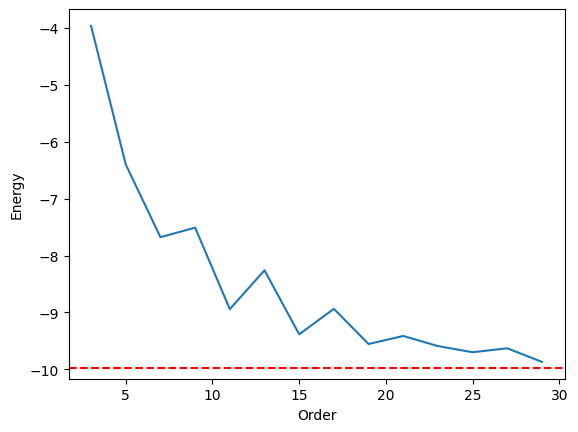

In [865]:
nqubits = 6
H_def = sum([X(x)*X(x+1)+Y(x)*Y(x+1)+Z(x+1)*Z(x)  for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
eigenvalues = np.linalg.eigvalsh(H)
E = eigenvalues[0]
gap = getGap(H)
print(eigenvalues)
print(f"Gap: {gap}")
mu = E+gap/2
alpha = np.linalg.norm(H)
H_new = (H-mu*np.eye(2**nqubits))/(alpha+mu)
print(np.linalg.eigvalsh(H_new))
initState = np.random.rand(2**nqubits)
initState /= np.linalg.norm(initState)

orders = np.arange(1, 15, 1)
energy = np.zeros((len(orders+1)))
energy[0] = np.real(initState.conj().T @ H @ initState)
for i in range(len(orders)):
    coeffs = sgnPolyCoefficients(orders[i])
    coeffs = np.flip(coeffs)
    roots = np.roots(coeffs)
    newState = thermalStatePrepMatrixPolynomialState(H_new, roots, initState)
    newState /= np.linalg.norm(newState)
    energy[i] = np.real(newState.conj().T @ H @ newState)

plt.figure()
plt.plot(2*orders+1, energy, label = 'Polynomial approximation')
plt.axhline(E, color='red', linestyle='--', label = 'Ground state energy')
plt.xlabel("Order")
plt.ylabel("Energy")


In [53]:
def powerMethod(H, initState, lamb, iters):
    I = np.eye(H.shape[0])
    state = initState.copy()
    energy = np.empty(iters+1)
    energy[0] = np.real(state.conj().T @ H @ state)
    for i in range(iters):
        state = (lamb*I - H) @ state
        state /= np.linalg.norm(state)
        energy[i+1] = np.real(state.conj().T @ H @ state)
    return state, energy


[Qibo 0.2.16|WARNING|2025-04-17 09:49:53]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


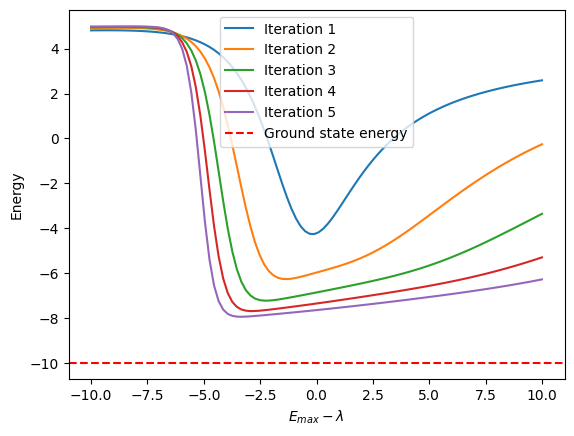

In [24]:
nqubits = 6
H_def = sum([X(x)*X(x+1)+Y(x)*Y(x+1)+Z(x+1)*Z(x)  for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
Emax = np.linalg.eigvalsh(H)[-1]
E0 = np.linalg.eigvalsh(H)[0]

lamb = np.linspace(Emax-10, Emax+10, 100)
initState = np.random.rand(2**nqubits)
initState /= np.linalg.norm(initState)
iters = 5
energies = np.zeros((len(lamb),iters))
for i in range(len(lamb)):
    state, energy = powerMethod(H, initState, lamb[i], iters)
    energies[i,:] = energy[1:]
    
plt.figure()
for i in range(iters):
    plt.plot(lamb-Emax, energies[:,i], label = f'Iteration {i+1}')
plt.axhline(E0, color='red', linestyle='--', label = 'Ground state energy')
plt.xlabel(r"$E_{max} - \lambda$")
plt.ylabel("Energy")
plt.legend()
    

[Qibo 0.2.16|WARNING|2025-04-17 10:44:34]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


-13.499730394751563


100%|██████████| 100/100 [07:29<00:00,  4.49s/it]


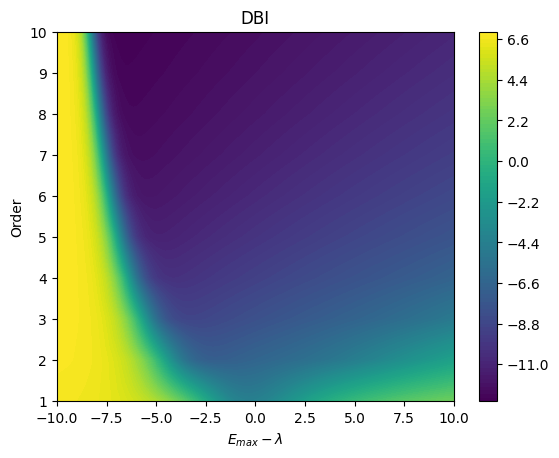

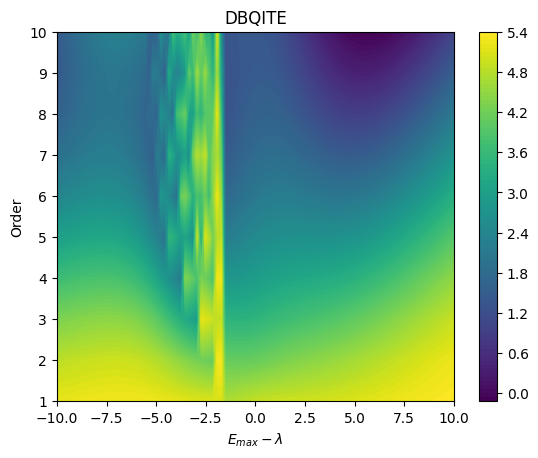

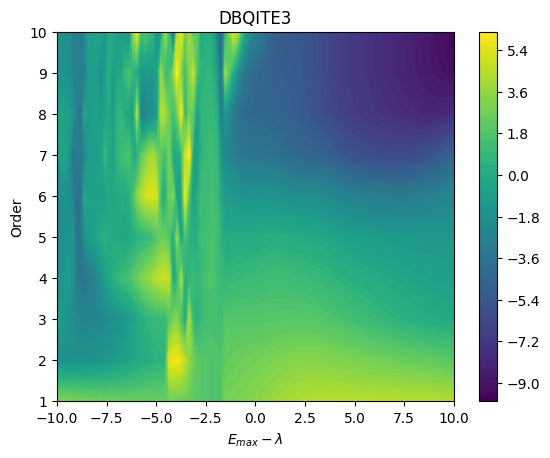

In [51]:
nqubits = 8
H_def = sum([X(x)*X(x+1)+Y(x)*Y(x+1)+Z(x+1)*Z(x)  for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
eigenvalues, eigenvectors = np.linalg.eigh(H)

Emax = eigenvalues[-1]
E0 = eigenvalues[0]

print(E0)
initState = np.random.rand(2**nqubits)+1j*np.random.rand(2**nqubits)
initState /= np.linalg.norm(initState)

lamb = np.linspace(Emax-10, Emax+10, 100)
order = 10
energyDBI = np.zeros((len(lamb), order))
energyDBQITE = np.zeros((len(lamb), order))
energyDBQITE3 = np.zeros((len(lamb), order))

for i in tqdm(range(len(lamb))):
    roots = np.ones(order)*lamb[i]

    _, energies = matrixPolynomialEvolutionDBI(initState, H, roots, method = "DBI")
    energyDBI[i,:] = energies

    _, energies = matrixPolynomialEvolutionDBI(initState, H, roots, method = "DBQITE")
    energyDBQITE[i,:] = energies

    _, energies = matrixPolynomialEvolutionDBI(initState, H, roots, method = "DBQITE3")
    energyDBQITE3[i,:] = energies

plt.figure()
plt.title("DBI")
plt.contourf(lamb-Emax, np.arange(1,order+1,1), energyDBI.T, levels=100)
plt.xlabel(r"$E_{max} - \lambda$")
plt.ylabel("Order")
plt.colorbar()

plt.figure()
plt.title("DBQITE")
plt.contourf(lamb-Emax, np.arange(1,order+1,1), energyDBQITE.T, levels=100)
plt.xlabel(r"$E_{max} - \lambda$")
plt.ylabel("Order")
plt.colorbar()


plt.figure()
plt.title("DBQITE3")
plt.contourf(lamb-Emax, np.arange(1,order+1,1), energyDBQITE3.T, levels=100)
plt.xlabel(r"$E_{max} - \lambda$")
plt.ylabel("Order")
plt.colorbar()


[Qibo 0.2.16|WARNING|2025-04-17 11:29:32]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


-17.03214082913152


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


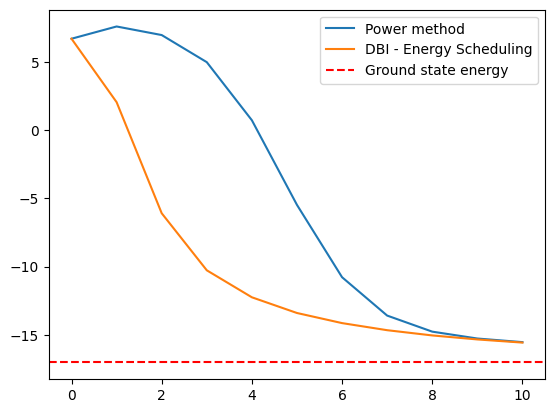

In [ ]:
nqubits = 10
H_def = sum([X(x)*X(x+1)+Y(x)*Y(x+1)+Z(x+1)*Z(x)  for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
eigenvalues, eigenvectors = np.linalg.eigh(H)

Emax = eigenvalues[-1]
E0 = eigenvalues[0]
refState = eigenvectors[:,0]

print(E0)
initState = np.random.rand(2**nqubits)+1j*np.random.rand(2**nqubits)
initState /= np.linalg.norm(initState)

lamb = np.linspace(Emax-10, Emax+10, 100)
order = 10
energyPowerMethod = np.zeros((len(lamb), order+1))
energyDBI = np.zeros(order+1)
state = np.copy(initState)
initEnergy = np.real(state.conj().T @ H @ state)   
energyPowerMethod[:,0] = initEnergy*np.ones(len(lamb))
energyDBI[0] = initEnergy

for i in tqdm(range(len(lamb))):

    _, energies = powerMethod(H, initState, lamb[i], order)
    energyPowerMethod[i,1:] = energies[1:]

for j in range(order):
    _, state, _  = optimalDBI(H, state, refState, method = "DBI", scheduling = 'Energy', iters = 1)
    energyDBI[j+1] = np.real(state.conj().T @ H @ state)



best = np.argmin(energyPowerMethod[:,-1])
plt.figure()
plt.plot(energyPowerMethod[best,:], label = 'Power method')
plt.plot(energyDBI, label = 'DBI - Energy Scheduling')
plt.axhline(E0, color='red', linestyle='--', label = 'Ground state energy')
plt.legend()
